In [1]:
from tensorflow.keras.datasets.fashion_mnist import load_data

(X_train, y_train), (X_test, y_test) = load_data()
# Shape model
print('Train shape: ', X_train.shape, y_train.shape)
print('Test shape : ', X_test.shape, y_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
Train shape:  (60000, 28, 28) (60000,)
Test shape :  (10000, 28, 28) (10000,)


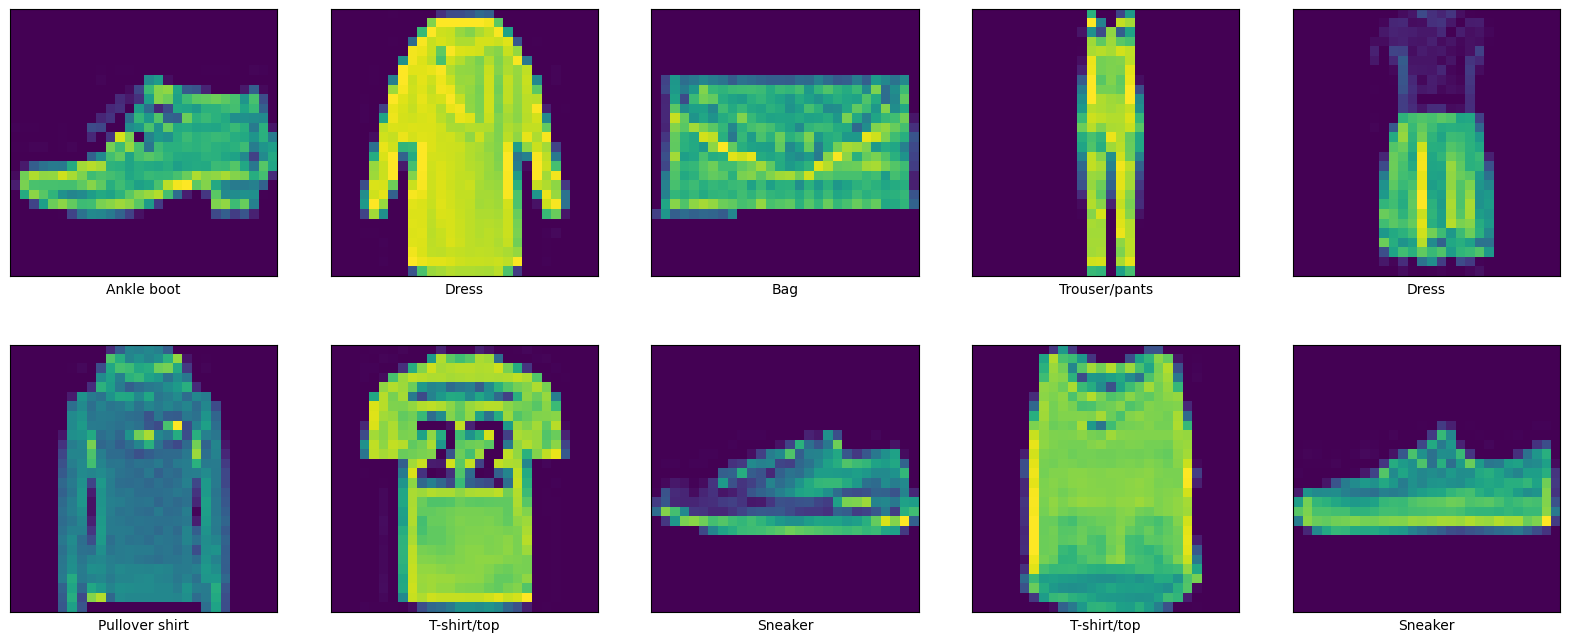

In [3]:
import matplotlib.pyplot as plt
import numpy as np


class_names = {
    0: "T-shirt/top",
  1: "Trouser/pants",
  2: "Pullover shirt",
  3: "Dress",
  4: "Coat",
  5: "Sandal",
  6: "Shirt",
  7: "Sneaker",
  8: "Bag",
  9: "Ankle boot"
}
idxs = np.arange(X_train.shape[0])
plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(idxs, 10)):
    plt.subplot(2, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[idx])

    # plt.imshow(X_train[idx], c_map='gray_r')
    plt.xlabel(class_names[y_train[idx]])
plt.show()

In [4]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, LeakyReLU, Embedding, Concatenate, Reshape, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

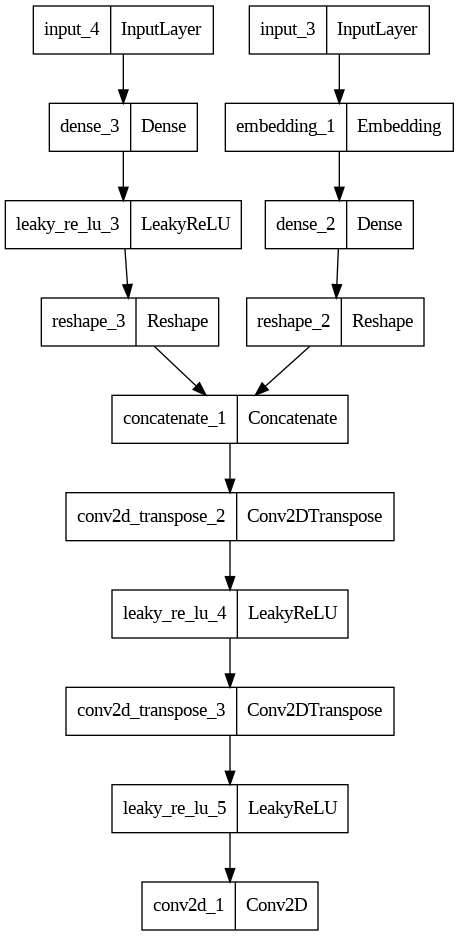

In [6]:
from tensorflow.keras.utils import plot_model
def Build_Generator(latent_dim=100, n_classes=10):
  y_label = Input(shape=(1,))
  li = Embedding(n_classes, 50)(y_label)
  n_shape = 7 * 7
  li = Dense(n_shape)(li)
  li = Reshape((7, 7, 1))(li)


  in_lat = Input(shape=(latent_dim,))
  n_shape = 128 * 7 * 7
  gen = Dense(n_shape)(in_lat)
  gen = LeakyReLU(alpha=0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)

  merge = Concatenate()([gen, li])


  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
  gen = LeakyReLU(alpha=0.2)(gen)

  gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
  gen = LeakyReLU(alpha=0.2)(gen)
  # output
  out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
  # model
  model = Model([in_lat, y_label], out_layer)
  return model

generator = Build_Generator(latent_dim=100, n_classes=10)
plot_model(generator)

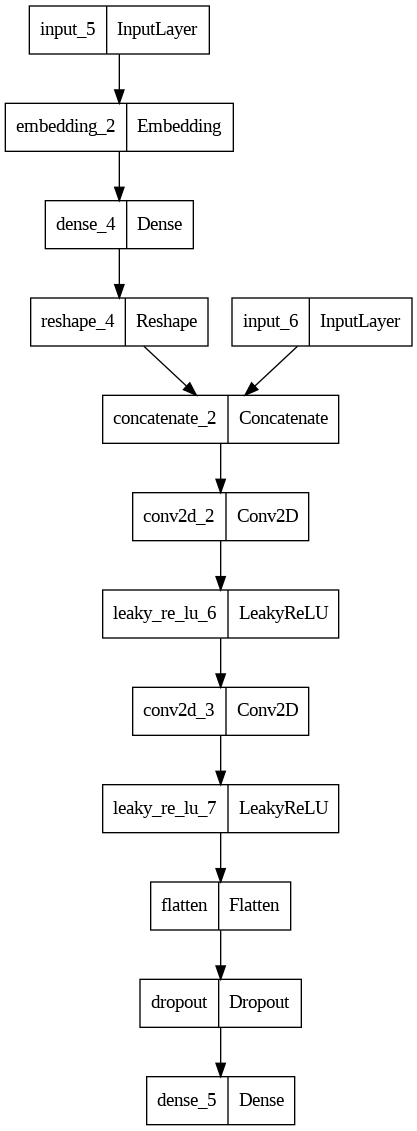

In [7]:
def Build_Discriminator(input_shape=(28, 28, 1), n_classes = 10):
   y_label = Input(shape=(1,))
   y_embedding = Embedding(n_classes, 50)(y_label)
   n_shape = input_shape[0] * input_shape[1]
   li = Dense(n_shape)(y_embedding)
   li = Reshape((input_shape[0], input_shape[1], 1))(li)


   inpt_image = Input(shape=(28, 28, 1))


   concat = Concatenate()([inpt_image, li])

   fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(concat)
   fe = LeakyReLU(alpha=0.2)(fe)

   fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
   fe = LeakyReLU(alpha=0.2)(fe)


   fe = Flatten()(fe)
   fe = Dropout(0.4)(fe)
   out_layer = Dense(1, activation='sigmoid')(fe)


   model = Model([inpt_image, y_label], out_layer)
   opt = Adam(lr=0.0002, beta_1=0.5)
   model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
   return model
discriminator = Build_Discriminator(input_shape=(28, 28, 1), n_classes = 10)
plot_model(discriminator)

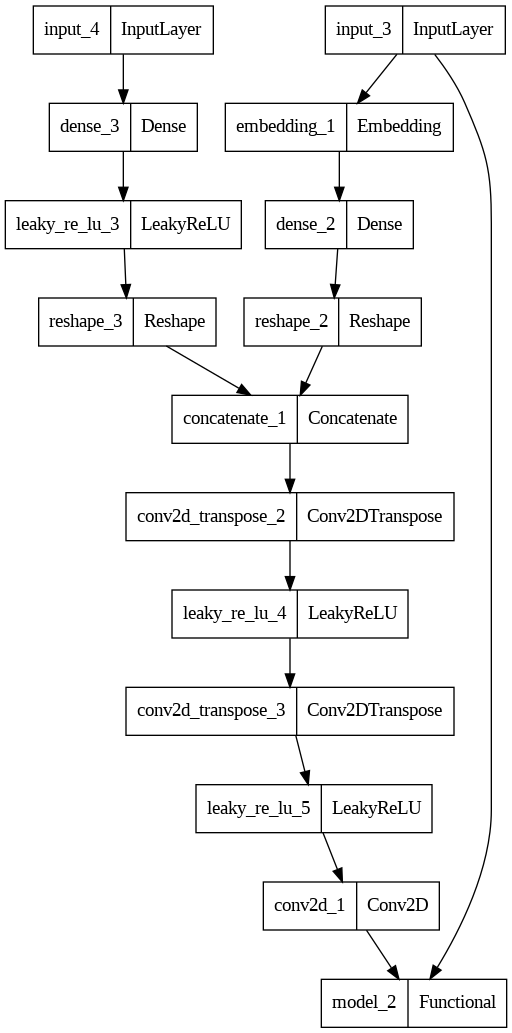

In [10]:

def Build_Conditional_GAN(g_model, d_model):

	d_model.trainable = False
	gen_noise, gen_label = g_model.input
	gen_output = g_model.output
	gan_output = d_model([gen_output, gen_label])
	model = Model([gen_noise, gen_label], gan_output)
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

cGAN_model = Build_Conditional_GAN(generator, discriminator)
plot_model(cGAN_model)

In [11]:
def _standardize_data(X_train, y_train):
	X = np.expand_dims(X_train, axis=-1)
	X = X.astype('float32')
	X = (X - 127.5) / 127.5
	return [X, y_train]

In [12]:
def _generate_real_samples(dataset, n_samples):
	images, labels = dataset

	ix = np.random.randint(0, images.shape[0], n_samples)
	X, labels = images[ix], labels[ix]
	y = np.ones((n_samples, 1))
	return [X, labels], y

In [13]:
def _generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = np.random.randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = np.random.randint(0, n_classes, n_samples)
	return [z_input, labels]


def _generate_fake_samples(generator, latent_dim, n_samples):
	z_input, labels_input = _generate_latent_points(latent_dim, n_samples)
	images = generator.predict([z_input, labels_input])
	y = np.zeros((n_samples, 1))
	return [images, labels_input], y

In [16]:
def train(g_model, d_model, cGAN_model, dataset, latent_dim, n_epochs=100, n_batch=128, save_every_epochs=10):

	batch_per_epoch = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)

	for i in range(n_epochs):

		for j in range(batch_per_epoch):

			[X_real, labels_real], y_real = _generate_real_samples(dataset, half_batch)
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			[X_fake, labels], y_fake = _generate_fake_samples(g_model, latent_dim, half_batch)
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			[z_input, labels_input] = _generate_latent_points(latent_dim, n_batch)
			y_gan = np.ones((n_batch, 1))
			g_loss = cGAN_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
	if (i % save_every_epochs) & (i > 0):
		g_model.save('cGAN_generator_epoch{}.h5'.format(i))

	g_model.save('cGAN_generator.h5')

In [ ]:
latent_dim = 100

d_model = Build_Discriminator()

g_model = Build_Generator(latent_dim)

cGAN_model = Build_Conditional_GAN(g_model, d_model)

dataset = _standardize_data(X_train, y_train)
# train model
train(g_model, d_model, cGAN_model, dataset, latent_dim)

2/2 [==============================] - 0s 174ms/step
>1, 1/468, d1=0.685, d2=0.706 g=0.687
2/2 [==============================] - 0s 150ms/step
>1, 2/468, d1=0.369, d2=0.824 g=0.607
2/2 [==============================] - 0s 152ms/step
>1, 3/468, d1=0.213, d2=1.206 g=0.558
2/2 [==============================] - 0s 156ms/step
>1, 4/468, d1=0.190, d2=1.025 g=0.897
2/2 [==============================] - 1s 243ms/step
>1, 5/468, d1=0.317, d2=0.492 g=1.576
2/2 [==============================] - 0s 149ms/step
>1, 6/468, d1=0.446, d2=0.248 g=2.117
2/2 [==============================] - 0s 152ms/step
>1, 7/468, d1=0.255, d2=0.125 g=2.691
2/2 [==============================] - 0s 166ms/step
>1, 8/468, d1=0.380, d2=0.104 g=2.607
2/2 [==============================] - 0s 149ms/step
>1, 9/468, d1=0.327, d2=0.118 g=2.519
2/2 [==============================] - 0s 152ms/step
>1, 10/468, d1=0.184, d2=0.106 g=2.744
2/2 [==============================] - 0s 153ms/step
>1, 11/468, d1=0.250, d2=0.097 g=2.8

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	x_input = randn(latent_dim * n_samples)
	z_input = x_input.reshape(n_samples, latent_dim)
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()


model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)